In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, theta):
    """
    计算旋转后的二维高斯矩阵（numpy数组）
    
    :param x: x轴坐标的网格（numpy数组）
    :param y: y轴坐标的网格（numpy数组）
    :param mu_x: x轴方向的均值（高斯中心的x轴坐标）
    :param mu_y: y轴方向的均值（高斯中心的y轴坐标）
    :param sigma_x: x轴方向的标准差（控制高斯在x轴方向的扩展）
    :param sigma_y: y轴方向的标准差（控制高斯在y轴方向的扩展）
    :param theta: 旋转角度（弧度，控制高斯函数的旋转）
    :return: 旋转后的二维高斯矩阵（numpy数组）
    """
    # 旋转矩阵参数
    a = np.cos(theta) ** 2 / (2 * sigma_x ** 2) + np.sin(theta) ** 2 / (2 * sigma_y ** 2)
    b = -np.sin(2 * theta) / (4 * sigma_x ** 2) + np.sin(2 * theta) / (4 * sigma_y ** 2)
    c = np.sin(theta) ** 2 / (2 * sigma_x ** 2) + np.cos(theta) ** 2 / (2 * sigma_y ** 2)

    # 计算高斯值
    return np.exp(-(a * (x - mu_x) ** 2 + 2 * b * (x - mu_x) * (y - mu_y) + c * (y - mu_y) ** 2))

In [3]:
def gaussian_mask(tensor, mask_rate=None, sigma_x=None, sigma_y=None, theta=None):
    """
    高斯掩码
    
    :param tensor: 输入的二维张量
    :param mask_rate: 掩码率，范围0-1
    :param sigma_x: 高斯分布x轴方向的标准差
    :param sigma_y: 高斯分布y轴方向的标准差
    :param theta: 旋转角度（弧度，控制高斯函数的旋转）
    :return: 掩码后的二维张量和高斯矩阵
    """
    mask_rate = mask_rate or np.random.uniform(0, 1)
    sigma_x = sigma_x or np.random.uniform(0, 100)
    sigma_y = sigma_y or np.random.uniform(0, 100)
    theta = theta or np.random.uniform(0, 2 * np.pi)

    size_x, size_y = tensor.shape
    
    max_val = torch.max(tensor)
    max_pos = torch.where(tensor == max_val)
    mu_x, mu_y = max_pos[0].item(), max_pos[1].item()
    
    x, y = np.linspace(0, size_x - 1, size_x), np.linspace(0, size_y - 1, size_y)
    x, y = np.meshgrid(x, y)

    gaussian_matrix = gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y, theta)
    gaussian_matrix = torch.from_numpy(gaussian_matrix).float()
    
    num_elements = int(size_x * size_y * mask_rate)
    _, indices = torch.topk(gaussian_matrix.view(-1), num_elements)
    
    mask = torch.zeros_like(tensor)
    mask.view(-1)[indices] = 1
    masked_tensor = tensor * (1 - mask)

    return masked_tensor, gaussian_matrix

In [4]:
tensor = torch.randn(32, 32)

In [5]:
masked_tensor, gaussian_matrix = gaussian_mask(tensor, mask_rate=0.25)

print("Tensor:\n", tensor)
print("Masked Tensor:\n", masked_tensor)
print("Gaussian Matrix:\n", gaussian_matrix)

Tensor:
 tensor([[-0.4376,  0.6435, -1.3384,  ...,  0.5283, -0.2505, -0.4612],
        [ 0.5911,  0.3242,  0.6993,  ..., -0.8058,  0.4928,  0.1043],
        [-0.6291, -1.1249,  0.2410,  ..., -0.2532,  0.2839,  0.2273],
        ...,
        [ 2.4467, -0.7780,  0.7836,  ...,  0.2600, -1.0925, -0.1117],
        [ 1.4722, -1.0303,  0.1043,  ...,  1.2171,  0.4371,  1.2570],
        [-1.5151, -0.0603,  0.6290,  ..., -1.1352, -0.2251, -1.0413]])
Masked Tensor:
 tensor([[-0.4376,  0.6435, -1.3384,  ...,  0.5283, -0.2505, -0.4612],
        [ 0.5911,  0.3242,  0.6993,  ..., -0.8058,  0.4928,  0.1043],
        [-0.6291, -1.1249,  0.2410,  ..., -0.2532,  0.2839,  0.2273],
        ...,
        [ 2.4467, -0.7780,  0.7836,  ...,  0.2600, -1.0925, -0.1117],
        [ 1.4722, -1.0303,  0.1043,  ...,  1.2171,  0.4371,  1.2570],
        [-1.5151, -0.0603,  0.6290,  ..., -1.1352, -0.2251, -1.0413]])
Gaussian Matrix:
 tensor([[0.8128, 0.8309, 0.8480,  ..., 0.7671, 0.7461, 0.7244],
        [0.8136, 0.8320, 

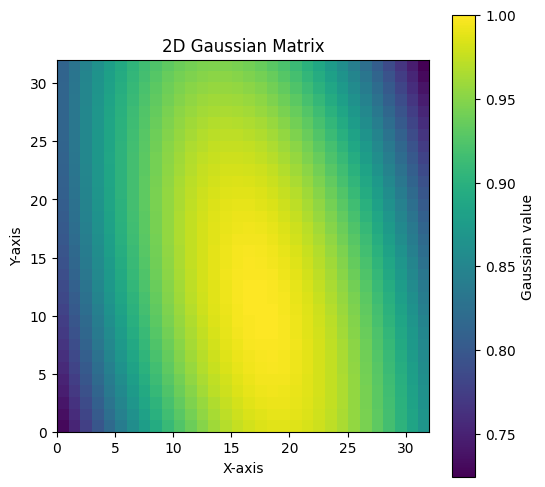

In [6]:
plt.figure(figsize=(6, 6))
plt.imshow(gaussian_matrix, cmap='viridis', extent=(0, 32, 0, 32))
plt.colorbar(label='Gaussian value')
plt.title('2D Gaussian Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

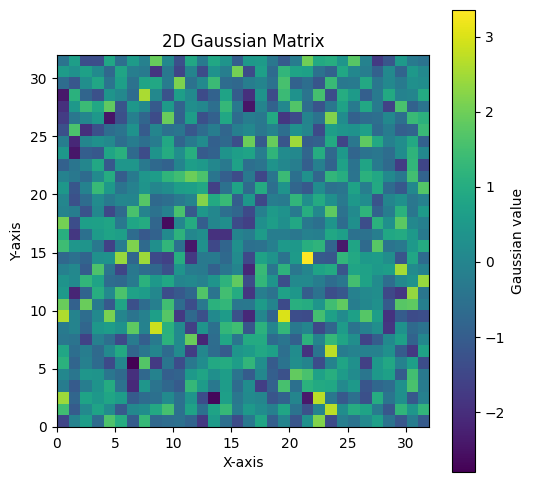

In [7]:
plt.figure(figsize=(6, 6))
plt.imshow(tensor, cmap='viridis', extent=(0, 32, 0, 32))
plt.colorbar(label='Gaussian value')
plt.title('2D Gaussian Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

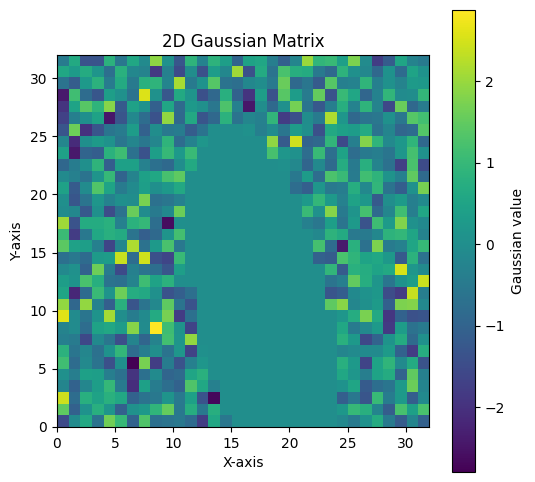

In [8]:
plt.figure(figsize=(6, 6))
plt.imshow(masked_tensor, cmap='viridis', extent=(0, 32, 0, 32))
plt.colorbar(label='Gaussian value')
plt.title('2D Gaussian Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [9]:
def batch_gaussian_mask(tensor, mask_ratio=None, sigma_x=None, sigma_y=None, theta=None):
    cloned_tensor = tensor.clone()
    # cloned_tensor: (batch_size, 1, aoa, tof) -> (batch_size, height, width)
    cloned_tensor = cloned_tensor.squeeze(1)

    gaussian_masked_cloned_tensors = [gaussian_mask(t, mask_ratio, sigma_x, sigma_y, theta)[0] for t in cloned_tensor]

    # (batch_size, height, width)
    gaussian_masked_cloned_tensor = torch.stack(gaussian_masked_cloned_tensors, dim=0)

    # (batch_size, height, width) -> (batch_size, 1, height, width)
    return gaussian_masked_cloned_tensor.unsqueeze(1)

In [10]:
tensor = torch.randn(4, 1, 32, 32)

In [11]:
gaussian_masked_tensor = batch_gaussian_mask(tensor)

In [12]:
gaussian_masked_tensor.shape

torch.Size([4, 1, 32, 32])